In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from mrmr_wrapper import MRMRTransformer
from sklearn.svm import SVC
import optuna
import optuna.visualization as vis
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

# Import Data

In [2]:
# Load the data
file_path = "features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

# Create binary labels (1,2 = 0; 4,5 = 1; exclude 3 for clearer separation)
binary_labels = labels_shuffled.apply(lambda x: 0 if x <= 2 else (1 if x >=4 else np.nan))
binary_data = data_shuffled[~binary_labels.isna()]
binary_labels = binary_labels[~binary_labels.isna()] 

Number of Comfort Score == 3: 100


# Train/Test Split

In [3]:
# For binary classification
X_train, X_test, y_train, y_test = train_test_split(
    binary_data,
    binary_labels,
    test_size=0.2,
    stratify=binary_labels,
    random_state=42
)

# Handle missing values

In [4]:
imputer = SimpleImputer(strategy='median')

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Scale Data
- Recommended for SVM models
- sklearn StandardScaler() may not work well with outliers (should check for outliers)

In [ ]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

# Optimize Feature Selection and SVM Parameters

In [ ]:
X = X_train_scaled.copy()
y = y_train.copy()

def binary_classification_objective(trial):
    # Feature selection, only optimizing method and number of features (no hyperparameters of the methods)
    fs_method = trial.suggest_categorical('feature_selection', ['MRMR', 'RFE', 'None'])
    
    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 5, 105, step = 10) # Only allow a maximum of 105 features to be selected, with a step of 10, to go up to all features: X.shape[1]
        if fs_method == 'RFE':
            estimator = RandomForestClassifier()
            selector = RFE(estimator, n_features_to_select=k_features)
        else: #MRMR
            selector = MRMRTransformer(k_features=k_features) #https://feature-engine.trainindata.com/en/1.8.x/api_doc/selection/MRMR.html#feature_engine.selection.MRMR
    else:
        selector = 'passthrough'
    
    # SVM hyperparameters 
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']) # do this first so that degree can be conditionally added later
            
    params = {
        'C': trial.suggest_float('C', 0.1, 100, log=True),
        'kernel': kernel,
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3,
        'probability': True,
        'random_state': 42
        }
    model = SVC(**params)

    # Pipeline
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"Error in trial: {e}")
        return -np.inf

# Run binary classification study
study = optuna.create_study(direction='maximize')
study.optimize(binary_classification_objective, n_trials=5, show_progress_bar=True)

# Print results
print("\nBinary Classification Optimization Results:")
print(f"Best ROC AUC Score: {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-09-02 08:55:49,105] A new study created in memory with name: no-name-9028e4cc-cab7-4a84-90e7-0cc232ab94da


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:03<00:00, 28.24it/s]


Got MRMR features


100%|██████████| 85/85 [00:02<00:00, 28.50it/s]


Got MRMR features


100%|██████████| 85/85 [00:02<00:00, 28.35it/s]


Got MRMR features


100%|██████████| 85/85 [00:02<00:00, 28.70it/s]


Got MRMR features


100%|██████████| 85/85 [00:03<00:00, 27.44it/s]


Got MRMR features
[I 2025-09-02 08:56:09,513] Trial 0 finished with value: 0.7585433085433084 and parameters: {'feature_selection': 'MRMR', 'k_features': 85, 'kernel': 'linear', 'C': 0.20694040343555906, 'gamma': 'auto'}. Best is trial 0 with value: 0.7585433085433084.
[I 2025-09-02 08:56:09,672] Trial 1 finished with value: 0.7329232495899163 and parameters: {'feature_selection': 'None', 'kernel': 'linear', 'C': 73.5961458618668, 'gamma': 'auto'}. Best is trial 0 with value: 0.7585433085433084.
[I 2025-09-02 09:00:23,134] Trial 2 finished with value: 0.7305404472071138 and parameters: {'feature_selection': 'RFE', 'k_features': 55, 'kernel': 'poly', 'C': 2.224180075712571, 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.7585433085433084.
[I 2025-09-02 09:00:23,261] Trial 3 finished with value: 0.5840825840825842 and parameters: {'feature_selection': 'None', 'kernel': 'poly', 'C': 0.2795498110767833, 'gamma': 'scale', 'degree': 5}. Best is trial 0 with value: 0.75854330854

# Visualization

In [ ]:
# 1. Parameter Importance Plot
fig = vis.plot_param_importances(study, target_name="ROC AUC Score")
fig.show()

# 2. Slice Plot (Best for seeing individual parameter effects)
fig = vis.plot_slice(
    study,
    params=['kernel', 'C', 'gamma'],
    target_name="ROC AUC Score"
)
fig.show()

# Apply Feature Selection to Train and Test Data

In [9]:
# apply your feature selection code from before
best_fs_method = study.best_params.get('feature_selection', 'None')

if best_fs_method != 'None':
    k_features = study.best_params['k_features']
    if best_fs_method == 'RFE':
        estimator = RandomForestClassifier()
        selector = RFE(estimator)
    elif best_fs_method == 'MRMR':
        selector = MRMRTransformer(k_features=k_features)
    
    selector.fit(X, y)
    if hasattr(selector, 'get_support'):  # For RFE
        selected_features = X.columns[selector.get_support()]
    else:  # For MRMR
        selected_features = selector.selected_features
    X_best = X[selected_features]
else:
    X_best = X
    selected_features = X.columns

# Apply the same feature selection to test data
if best_fs_method != 'None':
    if best_fs_method == 'MRMR':
        X_test_final = X_test_scaled[selected_features]
    else:
        X_test_final = selector.transform(X_test_scaled)  # Use the already fitted selector
        if isinstance(X_test_scaled, pd.DataFrame):
            X_test_final = pd.DataFrame(X_test_final, columns=selected_features)
else:
    X_test_final = X_test_scaled

100%|██████████| 85/85 [00:03<00:00, 28.28it/s]

Got MRMR features


# Create and Fit SVM Model with Best Parameters

In [10]:
best_model = SVC(
    C=study.best_params['C'],
    kernel=study.best_params['kernel'],
    gamma=study.best_params['gamma'],
    degree=study.best_params.get('degree', 3),  # Default degree if not in params
    probability=True,
    random_state=42
)

# Train on full (potentially feature-selected) data
best_model.fit(X_best, y)
params_dict = best_model.get_params()

# Plot Decision Boundary with PCA
- not confident in this, need to research what is actually going on here

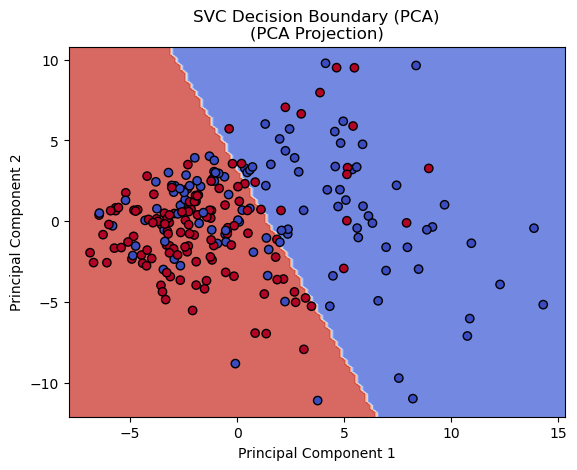

In [16]:
def plot_decision_boundary_pca(model, X, y, title="SVC Decision Boundary (PCA)"):
    """
    Project high-dimensional data to 2D using PCA for visualization
    """
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Train a new model on PCA-transformed data (for accurate boundary)
    model_pca = SVC(**params_dict)
    model_pca.fit(X_pca, y)
    
    # Plot decision boundary
    display = DecisionBoundaryDisplay.from_estimator(
        model_pca,
        X_pca,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
    )
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title(f"{title}\n(PCA Projection)")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Usage for high-dimensional data
plot_decision_boundary_pca(best_model, X_best, y)

# Run model and get outcomes


Final Model Evaluation on Test Set:
Accuracy: 0.6167
Precision: 0.6562
Recall: 0.6364
F1 Score: 0.6462
ROC AUC: 0.6880


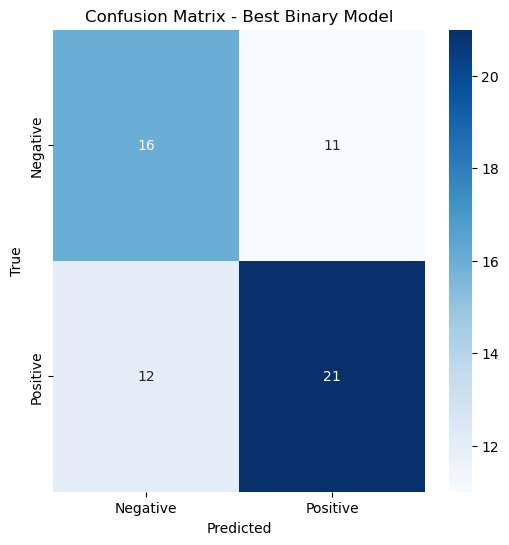

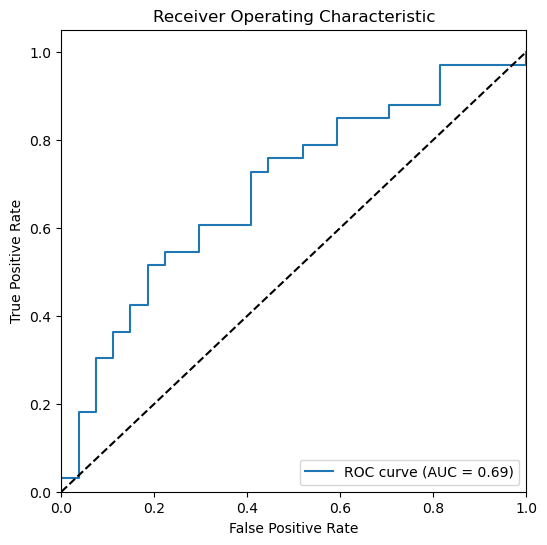

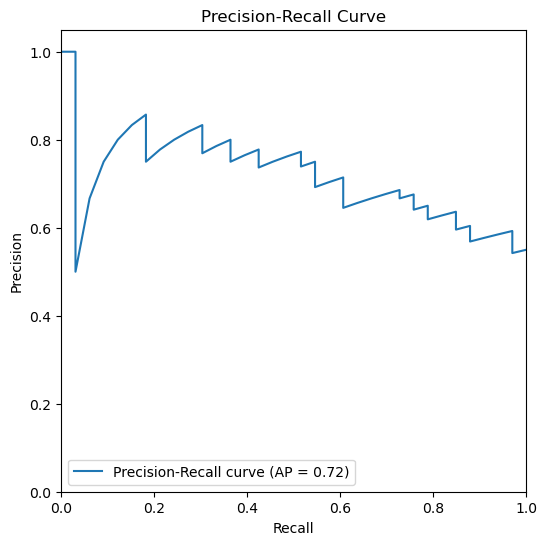

In [13]:
# Make predictions
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]  # Probabilities for class 1

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Best Binary Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()